##  基于单层决策树构建弱分类器

In [1]:
import numpy as np

In [2]:
def loadSimpData():
    datMat = np.mat([[ 1. ,  2.1],
        [ 2. ,  1.1],
        [ 1.3,  1. ],
        [ 1. ,  1. ],
        [ 2. ,  1. ]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat,classLabels

In [8]:
datMat, classLabels = loadSimpData()

#### 单层决策树生成函数

In [3]:
# 通过阈值比较对数据进行分类
# 分类器的阈值过滤函数，即设定某一阈值，凡是超过该阈值的结果被归为一类，小于阈值的结果都被分为另外一类
def stumpClassify(dataMatrix,dimen,threshVal,threshIneq):#just classify the data
    retArray = np.ones((np.shape(dataMatrix)[0],1))
    if threshIneq == 'lt':
        # 数组过滤
        retArray[dataMatrix[:,dimen] <= threshVal] = -1.0
    else:
        retArray[dataMatrix[:,dimen] > threshVal] = -1.0
    return retArray

找到最低错误率的单层决策树伪代码：
```
将最小错误率minError设为正无穷大
对数据集中的每一个特征（第一层循环）：
    对每个步长（第二层循环）：
        对每个不等号（第三层循环）：
            建立一棵单层决策树并利用加权数据集对它进行测试
            如果错误率低于minError，则将当前单层决策树设为最佳单层决策树
返回最佳单层决策树
```

In [4]:
# 遍历所有取值，基于权重向量D找到数据集上最佳的单层决策树
def buildStump(dataArr,classLabels,D):
    dataMatrix = np.mat(dataArr)
    labelMat = np.mat(classLabels).T
    m,n = np.shape(dataMatrix)
    # 步长或区间总数
    numSteps = 10.0   # 在特征的所有可能取值上进行遍历
    # 存储给定权重向量D时所得到的最佳单层决策树的相关信息（最优决策树信息）
    bestStump = {}
    # 最优单层决策树预测结果
    bestClasEst = np.mat(np.zeros((m,1)))
    # 将最小错误率初始化为正无穷大
    minError = np.inf 
    # 遍历每一列的特征值
    for i in range(n):#loop over all dimensions
        rangeMin = dataMatrix[:,i].min()
        rangeMax = dataMatrix[:,i].max()
        stepSize = (rangeMax-rangeMin)/numSteps
        # 遍历各个步长区间
        for j in range(-1,int(numSteps)+1):#loop over all range in current dimension
            # 两种阈值过滤模式
            for inequal in ['lt', 'gt']: #go over less than and greater than
                # 计算阈值
                threshVal = (rangeMin + float(j) * stepSize)
                #选定阈值后，调用阈值过滤函数分类预测
                predictedVals = stumpClassify(dataMatrix,i,threshVal,inequal)#call stump classify with i, j, lessThan
                # 初始化错误向量
                errArr = np.mat(np.ones((m,1)))
                # 将错误向量中分类正确项置0
                errArr[predictedVals == labelMat] = 0
                # 计算加权错误率
                weightedError = D.T*errArr  #calc total error multiplied by D
                #print ("split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (i, threshVal, inequal, weightedError))
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    # 返回最佳单层决策树相关信息的字典，最小错误率，决策树预测输出结果(分类器分类)
    return bestStump,minError,bestClasEst

In [6]:
# test
D = np.mat(np.ones((len(datMat),1))/len(datMat))
buildStump(datMat,classLabels,D)

split: dim 0, thresh 0.90, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 0.90, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.00, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.00, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.10, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.10, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.20, thresh ineqal: lt, the weighted error is 0.400
split: dim 0, thresh 1.20, thresh ineqal: gt, the weighted error is 0.600
split: dim 0, thresh 1.30, thresh ineqal: lt, the weighted error is 0.200
split: dim 0, thresh 1.30, thresh ineqal: gt, the weighted error is 0.800
split: dim 0, thresh 1.40, thresh ineqal: lt, the weighted error is 0.200
split: dim 0, thresh 1.40, thresh ineqal: gt, the weighted error is 0.800
split: dim 0, thresh 1.50, thresh ineqal: lt, the weighted error is 0.200
split: dim 0, thresh 1.50, thresh ineq

({'dim': 0, 'thresh': 1.3, 'ineq': 'lt'}, matrix([[0.2]]), array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

## 完整AdaBoost算法的实现

```
对每次迭代：
    利用buildStump()函数找到最佳的单层决策树
    将最佳单层决策树加入到单层决策树数组
    计算alpha
    计算新的权重向量D
    更新累计类别估计值
    如果错误率等于0.0，则推出循环
```

In [5]:
def adaBoostTrainDS(dataArr,classLabels,numIt=40):
    # 弱分类器相关信息列表
    weakClassArr = []
    m = np.shape(dataArr)[0]
    # init D to all equal
    D = np.mat(np.ones((m,1))/m)
    # 累计估计值向量
    aggClassEst = np.mat(np.zeros((m,1)))
    # 循环迭代次数
    for i in range(numIt):
        bestStump,error,classEst = buildStump(dataArr,classLabels,D)#build Stump
        #print ("D:",D.T)
        # calc alpha, max(error,eps)确保没有错误时不会发生除零溢出
        alpha = float(0.5*np.log((1.0-error)/max(error,1e-16)))
        # 字典存储单层决策树的系数
        bestStump['alpha'] = alpha
        # 将该决策树存入到列表
        weakClassArr.append(bestStump)
        #print ("classEst: ",classEst.T)
        # 更新权值向量
        expon = np.multiply(-1*alpha*np.mat(classLabels).T,classEst) #exponent for D calc, getting messy
        D = np.multiply(D,np.exp(expon))                              #Calc New D for next iteration
        D = D/D.sum()
        #calc training error of all classifiers, if this is 0 quit for loop early (use break)
        # 累加当前单层决策树的加权预测值
        aggClassEst += alpha*classEst
        #print ("aggClassEst: ",aggClassEst.T)
        # 求出分类错的样本数
        aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(classLabels).T,np.ones((m,1)))
        # 计算错误率
        errorRate = aggErrors.sum()/m
        #print ("total error: ",errorRate)
        if errorRate == 0.0:
            break
    # 返回弱分类器的组合列表
    return weakClassArr# ,aggClassEst

In [11]:
adaBoostTrainDS(datMat,classLabels,9)

D: [[0.2 0.2 0.2 0.2 0.2]]
classEst:  [[-1.  1. -1. -1.  1.]]
total error:  0.2
D: [[0.5   0.125 0.125 0.125 0.125]]
classEst:  [[ 1.  1. -1. -1. -1.]]
total error:  0.2
D: [[0.28571429 0.07142857 0.07142857 0.07142857 0.5       ]]
classEst:  [[1. 1. 1. 1. 1.]]
total error:  0.0


([{'dim': 0, 'thresh': 1.3, 'ineq': 'lt', 'alpha': 0.6931471805599453},
  {'dim': 1, 'thresh': 1.0, 'ineq': 'lt', 'alpha': 0.9729550745276565},
  {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.8958797346140273}],
 matrix([[ 1.17568763],
         [ 2.56198199],
         [-0.77022252],
         [-0.77022252],
         [ 0.61607184]]))

# 测试算法：基于AdaBoost的分类

将弱分类器的训练过程从程序中抽出来，然后应用到某个具体的实例上去。每个弱分类器的结果以其对应的alpha值作为权重。所有这些弱分类器的结果加权求和就得到了最后的结果。

In [6]:
def adaClassify(datToClass,classifierArr):
    """
    利用训练出的多个弱分类器进行分类
    :param datToClass: 一个或多个待分类样例
    :param classifierArr: 多个弱分类器组成的数组
    :return:
    """
    dataMatrix = np.mat(datToClass)#do stuff similar to last aggClassEst in adaBoostTrainDS
    m = np.shape(dataMatrix)[0]
    aggClassEst = np.mat(np.zeros((m,1)))
    # 遍历所有的弱分类器
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix,classifierArr[i]['dim'],classifierArr[i]['thresh'],\
                                 classifierArr[i]['ineq'])#call stump classify
        aggClassEst += classifierArr[i]['alpha']*classEst
        #print (aggClassEst)
    # 返回元素的符号（大于0返回+1，小于0返回-1）
    return np.sign(aggClassEst)

In [9]:
# test
classifierArr = adaBoostTrainDS(datMat,classLabels,30)
adaClassify([0,0],classifierArr)

matrix([[-1.]])

In [10]:
adaClassify([[5,5],[0,0]],classifierArr)

[[ 0.69314718]
 [-0.69314718]]
[[ 1.66610226]
 [-1.66610226]]
[[ 2.56198199]
 [-2.56198199]]


matrix([[ 1.],
        [-1.]])

------

## 示例：在一个数据集上应用AdaBoost进行分类

在马疝病数据集上应用AdaBoost分类器，预测欢迎疝病的马是否存活

### 自适应数据加载函数     

该函数能够自动检测出特征的数目，并假定最后一个特征是类别标签

In [10]:
def loadDataSet(fileName):      #general function to parse tab -delimited floats
    numFeat = len(open(fileName).readline().split('\t')) #get number of fields 
    dataMat = []
    labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr =[]
        curLine = line.strip().split('\t')
        for i in range(numFeat-1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat,labelMat

In [11]:
# test
fileName = 'C:\\Users\ms\Desktop\machinelearninginaction\Ch07\horseColicTraining2.txt'
datArr, labelArr = loadDataSet(fileName)
classifierArr = adaBoostTrainDS(datArr,labelArr)
classifierArr

[{'dim': 9, 'thresh': 3.0, 'ineq': 'gt', 'alpha': 0.4616623792657674},
 {'dim': 17, 'thresh': 52.5, 'ineq': 'gt', 'alpha': 0.31248245042467104},
 {'dim': 3,
  'thresh': 55.199999999999996,
  'ineq': 'gt',
  'alpha': 0.2868097320169577},
 {'dim': 18,
  'thresh': 62.300000000000004,
  'ineq': 'lt',
  'alpha': 0.23297004638939506},
 {'dim': 10, 'thresh': 0.0, 'ineq': 'lt', 'alpha': 0.19803846151213741},
 {'dim': 5, 'thresh': 2.0, 'ineq': 'gt', 'alpha': 0.18847887349020634},
 {'dim': 12, 'thresh': 1.2, 'ineq': 'lt', 'alpha': 0.15227368997476778},
 {'dim': 7, 'thresh': 1.2, 'ineq': 'gt', 'alpha': 0.15510870821690512},
 {'dim': 5, 'thresh': 0.0, 'ineq': 'lt', 'alpha': 0.13536197353359405},
 {'dim': 4,
  'thresh': 28.799999999999997,
  'ineq': 'lt',
  'alpha': 0.12521587326132078},
 {'dim': 11, 'thresh': 2.0, 'ineq': 'gt', 'alpha': 0.1334764812820767},
 {'dim': 9, 'thresh': 4.0, 'ineq': 'lt', 'alpha': 0.1418224325377107},
 {'dim': 14, 'thresh': 0.0, 'ineq': 'gt', 'alpha': 0.10264268449708028}

In [12]:
# 预测测试集
testArr, testLabelArr = loadDataSet('C:\\Users\ms\Desktop\machinelearninginaction\Ch07\horseColicTest2.txt')
prediction10 = adaClassify(testArr,classifierArr)
prediction10

matrix([[ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 

In [13]:
# 预测测试集上结果的错误率
errArr = np.mat(np.ones((len(testArr),1)))
errNum = errArr[prediction10 != np.mat(testLabelArr).T].sum()   # 预测错误总个数
errRate = errNum/len(testArr)   # 预测错误率
errRate

0.19402985074626866

## 不同弱分类器数目情况下AdaBoost测试和分类错误率

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号'-'显示为方块的问题

In [62]:
errRateList = []
errTestRateList  = []

for i in range(1,1000):
    # 训练数据集
    classifierArr = adaBoostTrainDS(datArr,labelArr,i)
    pre = adaClassify(datArr,classifierArr)
    errArr = np.mat(np.ones((len(labelArr),1)))
    errRate = errArr[pre != np.mat(labelArr).T].sum() / len(labelArr)
    errRateList.append(errRate)
    
    # 测试数据集
    preTest = adaClassify(testArr,classifierArr)
    errTest = np.mat(np.ones((len(testArr),1)))
    errTestRate = errTest[preTest != np.mat(testLabelArr).T].sum() / len(testLabelArr)
    errTestRateList.append(errTestRate)
    


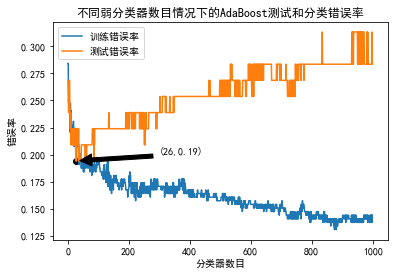

In [73]:
    
# 画图
plt.plot(range(1,1000,1),errRateList)
plt.plot(range(1,1000,1),errTestRateList)
plt.legend(['训练错误率','测试错误率'],loc='upper left')
plt.xlabel("分类器数目")
plt.ylabel("错误率")
plt.title("不同弱分类器数目情况下的AdaBoost测试和分类错误率")

# 标注
#for xy in zip(range(1,1000,10),errTestRateList):
#    minVal = min(errTestRateList)
#    if xy[1] == minVal:
#        plt.annotate("(%s,%s)" % xy, xy=xy,xytext=(50, min(errTestRateList)), textcoords='offset points')
plt.scatter(errTestRateList.index(min(errTestRateList)),min(errTestRateList),c='k',marker='o')
plt.annotate("(%s,%.4s)" % (errTestRateList.index(min(errTestRateList)),min(errTestRateList)), xy=(errTestRateList.index(min(errTestRateList)),
             min(errTestRateList)),xytext=(300, 0.2),arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()